In [ ]:
# Regression of the Higgs transverse momentum (visible or not) in ttH multilepton 

# Authored by Pietro Vischia pietro.vischia@cern.ch

2020-09-29: warning: I think last time I used this notebook I have modified the code without recreating the plots. Or the contrary. So basically the current code likely results in different plots than those stored here.

In [1]:
# First import stuff
import pandas as pd
import math
%matplotlib inline
import matplotlib #as matplot
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras import optimizers
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
print('Using matplotlib version', matplotlib.__version__)
print('Using sklearn version', sk.__version__)
print('Using tensorflow version', tf.__version__)
print('Using keras version', kr.__version__)

('Using matplotlib version', '2.2.3')
('Using sklearn version', '0.19.1')
('Using tensorflow version', '1.6.0')
('Using keras version', '2.1.4')


Using TensorFlow backend.


In [2]:
import os

#idir = 'inputs/2016' # old shit
#idir = 'inputs/2016_skimmed'
#idir = 'inputs/2016_skimmed_masses'
#idir = 'inputs/2016_skimmed_drll'
idir = '/nfs/user/pvischia/tth/dnn/inputs/2016_skimmed_drll_fix'
files_tth = [i for i in os.listdir(idir) if '.csv' in i and 'TTH' in i]
files_ttv = [i for i in os.listdir(idir) if '.csv' in i and ('TTZ' in i or 'TTW' in i )]
files_tt =  [i for i in os.listdir(idir) if '.csv' in i and 'TTJets' in i]

print('TTH files:', files_tth)
print('TTV files:', files_ttv)
print('TT  files:', files_tt )

data_tth = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_tth], ignore_index=True)
bkgs=False
data_ttv = None
data_tt = None
if bkgs:
    data_ttv = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_ttv], ignore_index=True)
    data_tt = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_tt], ignore_index=True)

print(len(data_tth))
data_tth.head()

('TTH files:', ['TTHnobb_fxfx_Friend.csv'])
('TTV files:', ['TTZToLLNuNu_amc_Friend.csv', 'TTWToLNu_fxfx_Friend.csv', 'TTZToLLNuNu_m1to10_Friend.csv', 'TTWW_Friend.csv'])
('TT  files:', ['TTJets_DiLepton_Friend.csv', 'TTJets_SingleLeptonFromT_Friend.csv', 'TTJets_SingleLeptonFromTbar_Friend.csv'])
73292


,Lep0_pt,Lep0_eta,Lep0_phi,Lep0_m,Lep1_pt,Lep1_eta,Lep1_phi,Lep1_m,Lep2_pt,Lep2_eta,...,HadTop_pt,HadTop_eta,HadTop_phi,HadTop_m,TopScore,met,met_phi,HTXS_Higgs_pt,HTXS_Higgs_y,evt_tag
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,83.12518,1.948036,-1.410353,211.13744,0.845590,90.565260,1.468018,214.726560,-0.013012,1.0
1,85.495810,-0.427185,-0.665771,-0.030975,55.812530,-0.643921,1.863281,0.105713,0.0,0.0,...,208.47572,-0.313433,-2.988216,183.79253,0.906676,35.686523,-0.213287,9.640625,-0.351501,143.0
2,51.678165,-0.693359,3.014160,0.021652,43.507114,-1.205566,-1.343506,0.105713,0.0,0.0,...,170.46568,-0.620395,0.121868,133.40097,0.805980,70.115780,-1.069580,274.281250,-0.585327,143.0
3,166.769620,-1.572510,-0.737061,0.105713,104.531030,0.073624,2.775879,0.018494,0.0,0.0,...,131.39407,-0.165173,1.182485,153.42674,0.963358,360.207600,-1.086914,390.718750,0.232483,143.0
4,34.635020,-0.681396,-2.715332,0.006443,28.760351,-0.886353,0.087830,0.105713,0.0,0.0,...,79.94824,2.784839,-0.154445,364.15940,0.347204,60.278694,-2.115723,91.554690,-0.717529,143.0


In [3]:
# There's no third lepton, jet mass not filled, 7 jets not stored
# HadTop (and the score) would be redundant if using the individual jets
# evt_tag is the leptonic flavour of the event, for later splitting. Must put it into a spectator variable
thevars = [
    'Lep0_pt', 'Lep0_eta', 'Lep0_phi','Lep0_m',
    'Lep1_pt', 'Lep1_eta', 'Lep1_phi','Lep1_m',
    #'Lep2_pt', 'Lep2_eta', 'Lep2_phi', # there's no third lepton
    'Jet0_pt','Jet0_eta','Jet0_phi','Jet0_m',#'Jet0_btagdiscr',#'Jet1_mass',
    'Jet1_pt','Jet1_eta','Jet1_phi','Jet1_m',#'Jet1_btagdiscr',#'Jet1_mass',
    'Jet2_pt','Jet2_eta','Jet2_phi','Jet2_m',#'Jet2_btagdiscr',#'Jet2_mass',
    'Jet3_pt','Jet3_eta','Jet3_phi','Jet3_m',#'Jet3_btagdiscr',#'Jet2_mass',
    'Jet4_pt','Jet4_eta','Jet4_phi','Jet4_m',#'Jet4_btagdiscr',#'Jet2_mass',
    'Jet5_pt','Jet5_eta','Jet5_phi','Jet5_m',#'Jet5_btagdiscr',#'Jet2_mass',
    'Jet6_pt','Jet6_eta','Jet6_phi','Jet6_btagdiscr',#'Jet2_mass',
    'HadTop_pt','HadTop_eta','HadTop_phi','HadTop_m',
    #'TopScore',
    'met',
    'met_phi',
#    'HTXS_Higgs_pt','HTXS_Higgs_y',
#    'evt_tag'
]

if 'deltars' in idir or 'drll' in idir:
    for j in range(6):
        for l in range(2):
            thevars.append('DeltaRl%sj%s'%(l,j))
    
        for jo in range(j,6):
            if j!= jo:
                thevars.append('DeltaRj%sj%s'%(j,jo))
    thevars.append('DeltaRl0l1')

spect = [ 'met']
thetarget = ['HTXS_Higgs_pt','HTXS_Higgs_y']
print('TRAINING FEATURES')
print(thevars)

TRAINING FEATURES
['Lep0_pt', 'Lep0_eta', 'Lep0_phi', 'Lep0_m', 'Lep1_pt', 'Lep1_eta', 'Lep1_phi', 'Lep1_m', 'Jet0_pt', 'Jet0_eta', 'Jet0_phi', 'Jet0_m', 'Jet1_pt', 'Jet1_eta', 'Jet1_phi', 'Jet1_m', 'Jet2_pt', 'Jet2_eta', 'Jet2_phi', 'Jet2_m', 'Jet3_pt', 'Jet3_eta', 'Jet3_phi', 'Jet3_m', 'Jet4_pt', 'Jet4_eta', 'Jet4_phi', 'Jet4_m', 'Jet5_pt', 'Jet5_eta', 'Jet5_phi', 'Jet5_m', 'Jet6_pt', 'Jet6_eta', 'Jet6_phi', 'Jet6_btagdiscr', 'HadTop_pt', 'HadTop_eta', 'HadTop_phi', 'HadTop_m', 'met', 'met_phi', 'DeltaRl0j0', 'DeltaRl1j0', 'DeltaRj0j1', 'DeltaRj0j2', 'DeltaRj0j3', 'DeltaRj0j4', 'DeltaRj0j5', 'DeltaRl0j1', 'DeltaRl1j1', 'DeltaRj1j2', 'DeltaRj1j3', 'DeltaRj1j4', 'DeltaRj1j5', 'DeltaRl0j2', 'DeltaRl1j2', 'DeltaRj2j3', 'DeltaRj2j4', 'DeltaRj2j5', 'DeltaRl0j3', 'DeltaRl1j3', 'DeltaRj3j4', 'DeltaRj3j5', 'DeltaRl0j4', 'DeltaRl1j4', 'DeltaRj4j5', 'DeltaRl0j5', 'DeltaRl1j5', 'DeltaRl0l1']


From 68174 available data 
 you selected 68174 of them


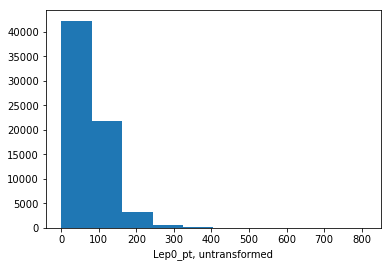

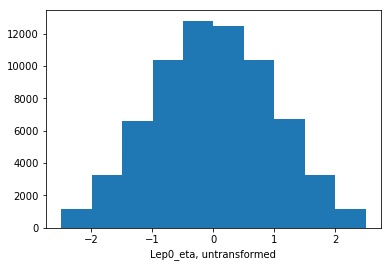

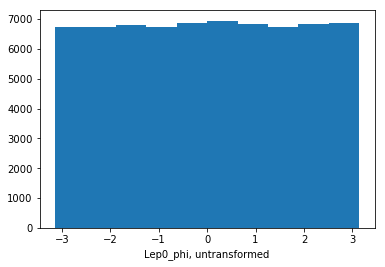

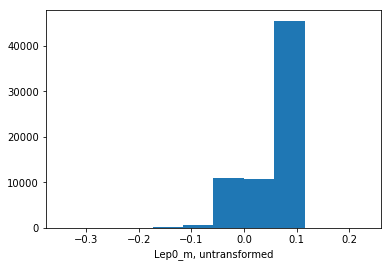

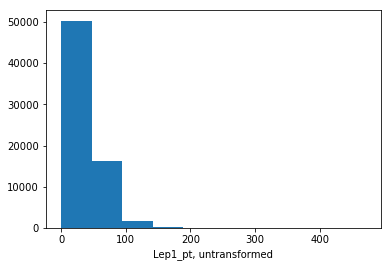

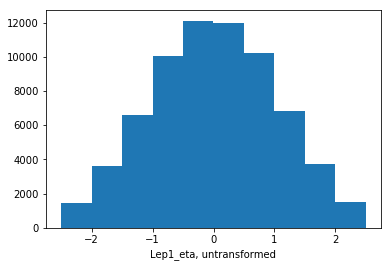

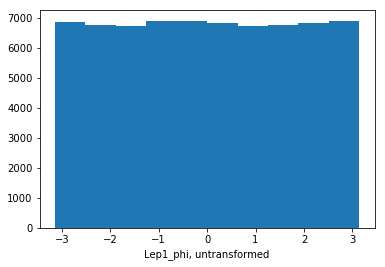

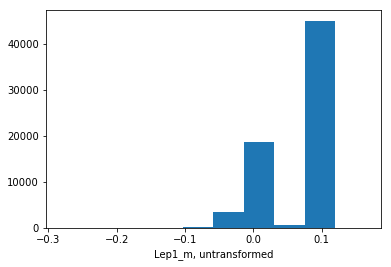

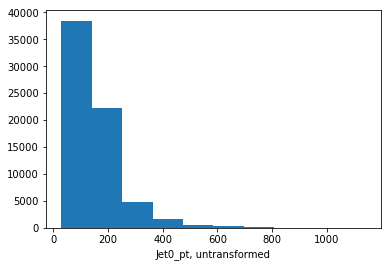

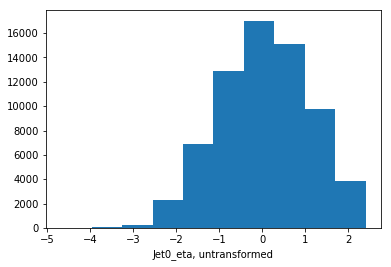

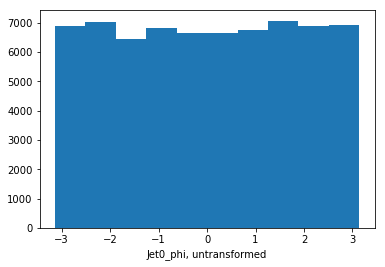

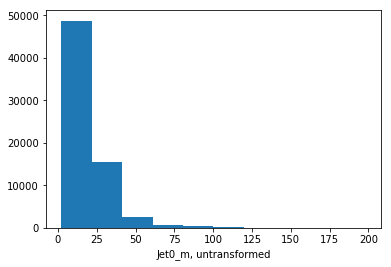

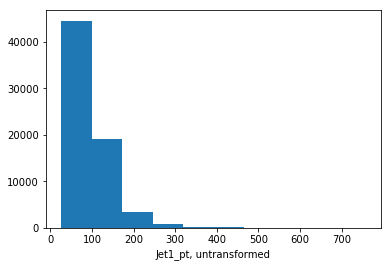

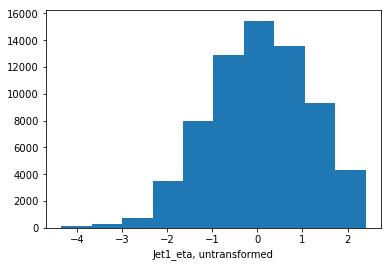

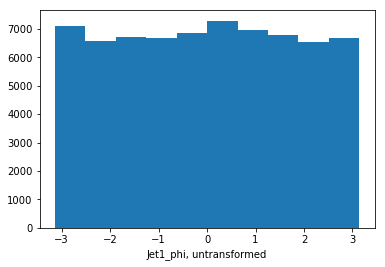

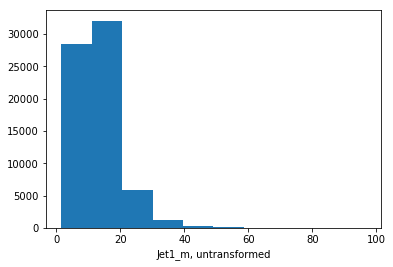

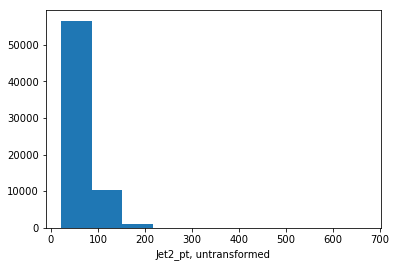

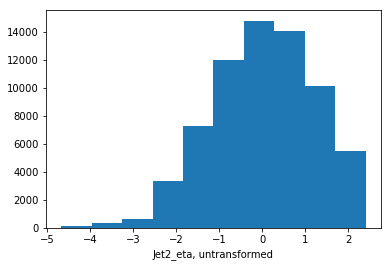

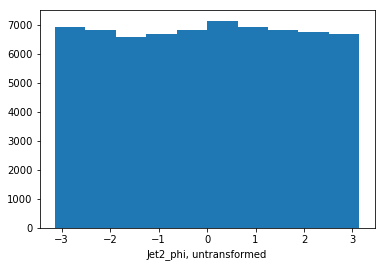

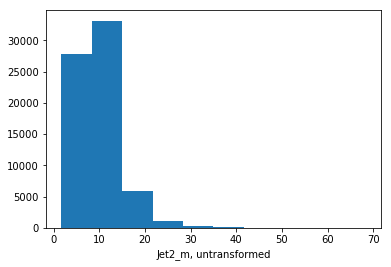

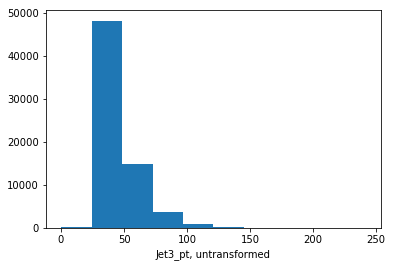

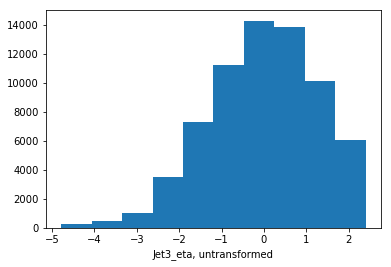

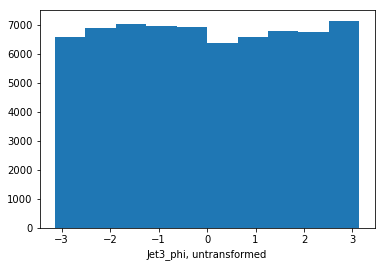

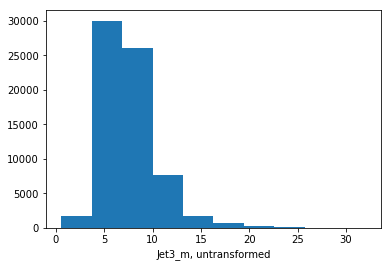

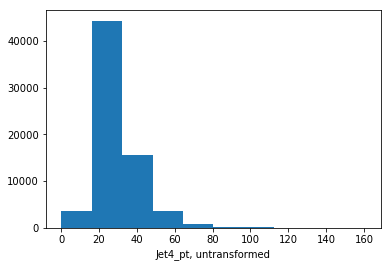

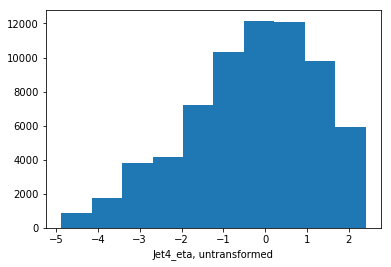

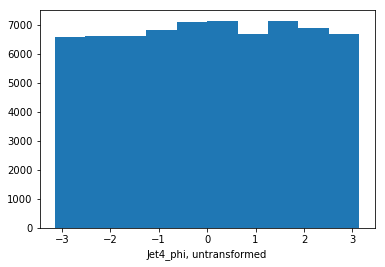

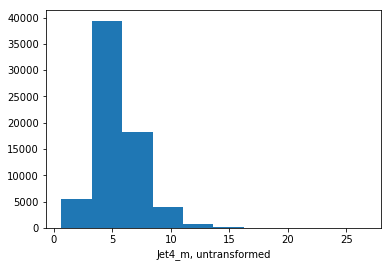

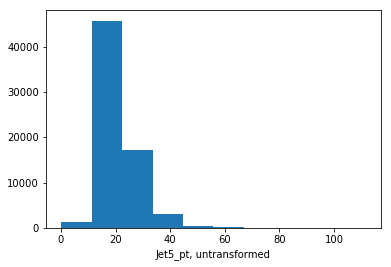

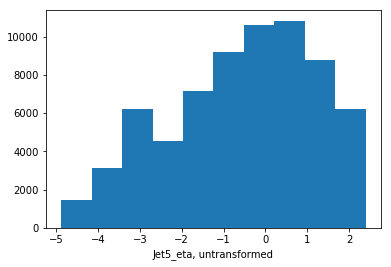

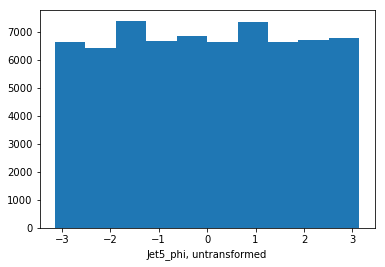

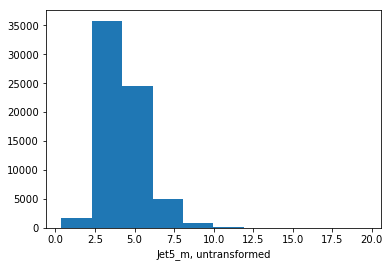

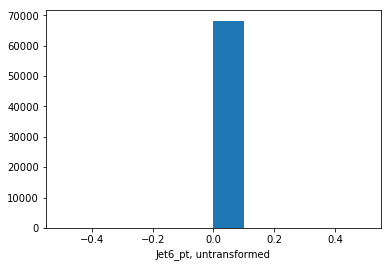

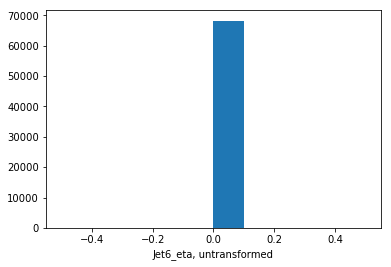

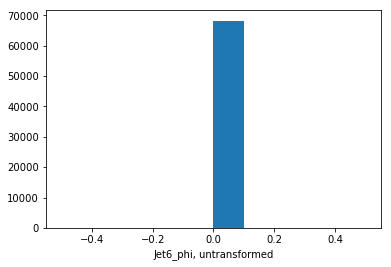

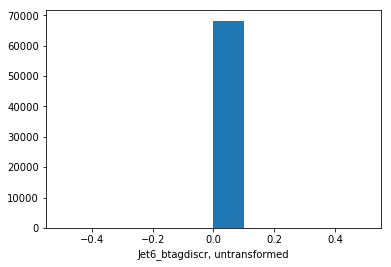

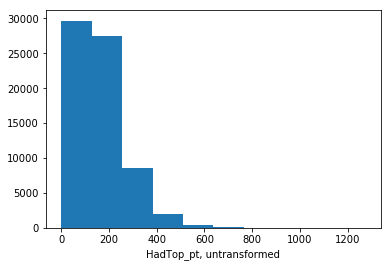

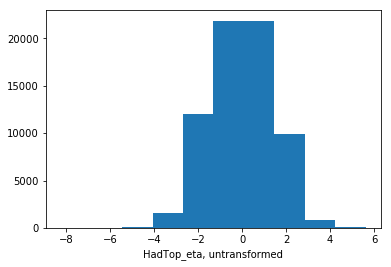

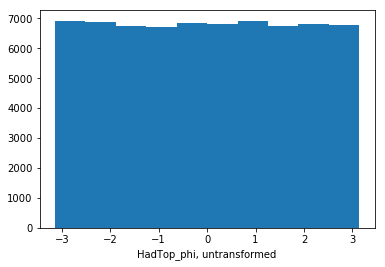

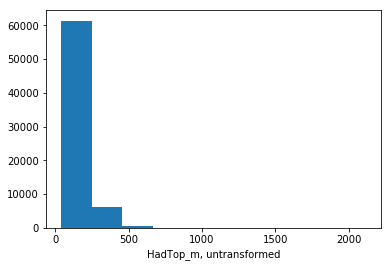

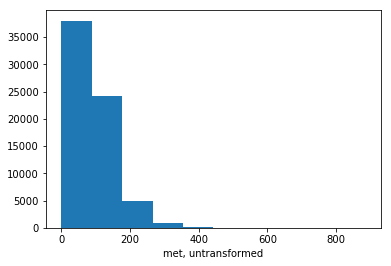

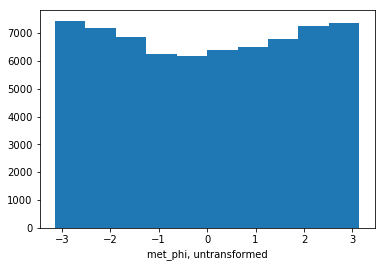

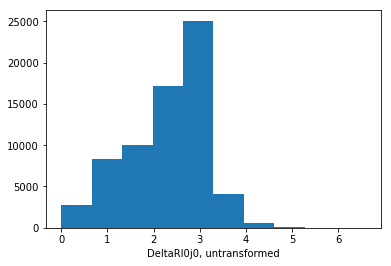

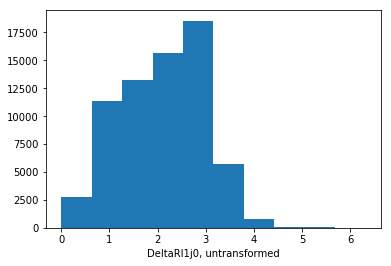

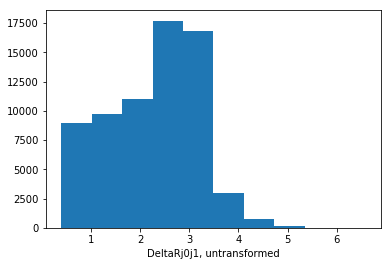

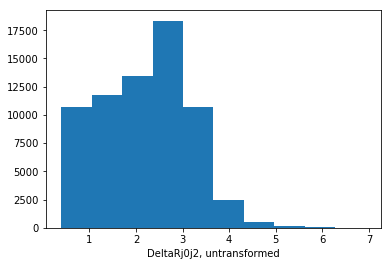

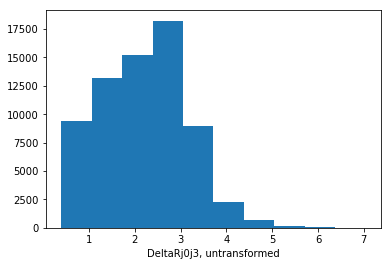

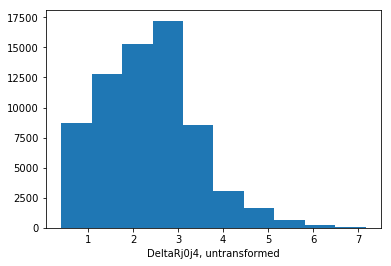

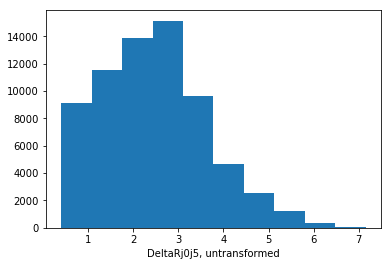

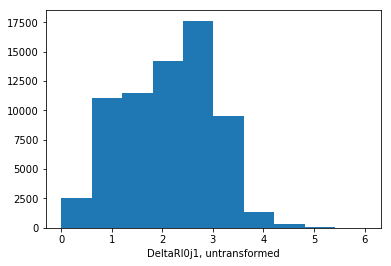

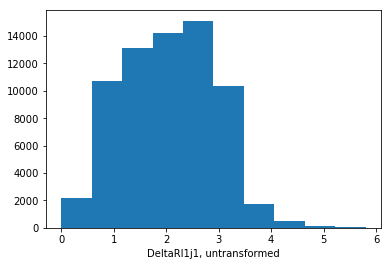

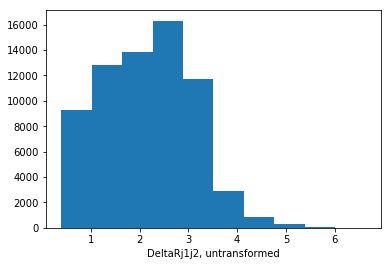

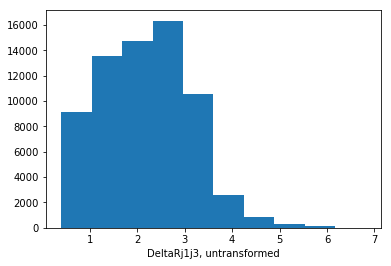

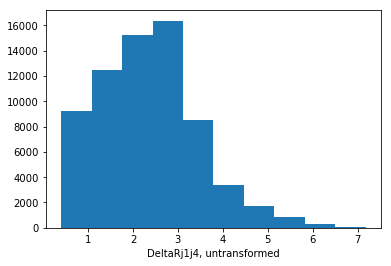

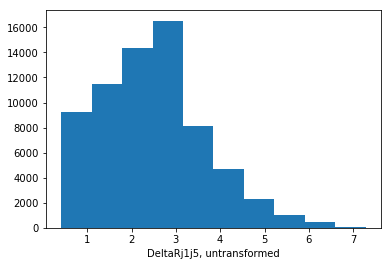

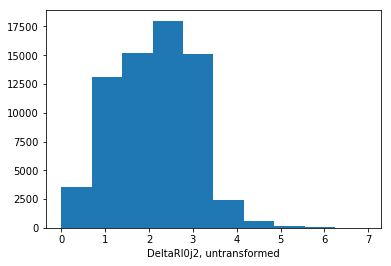

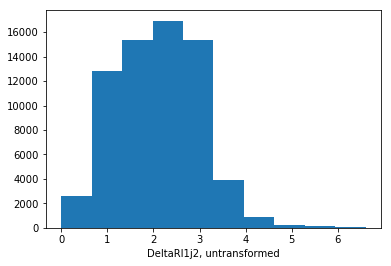

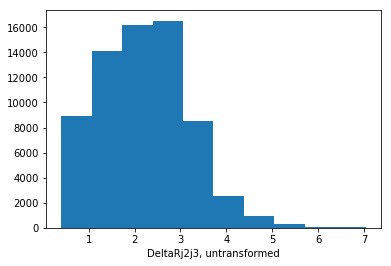

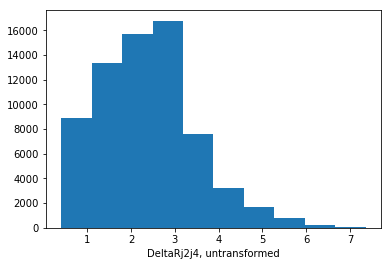

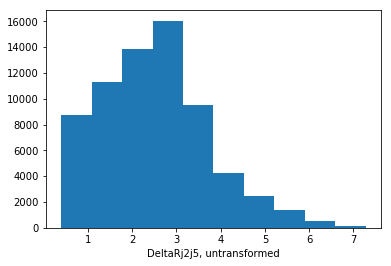

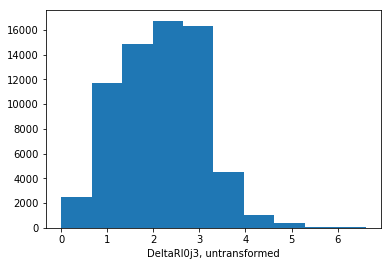

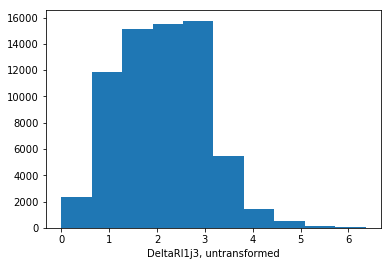

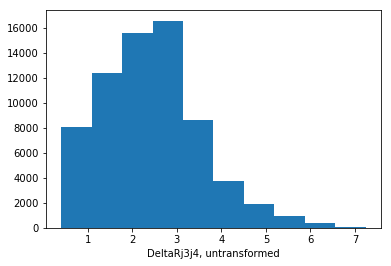

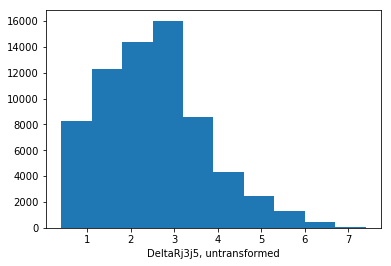

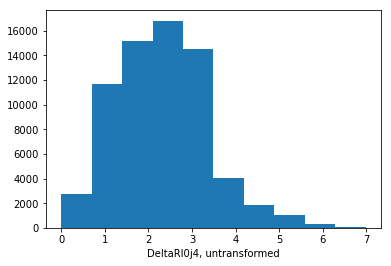

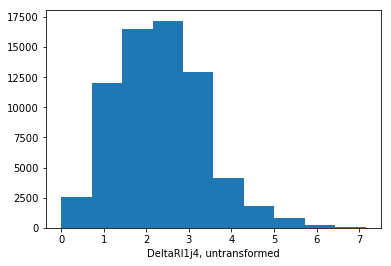

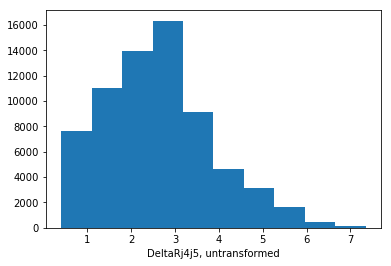

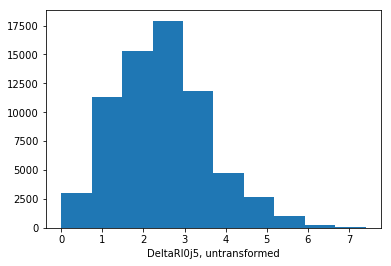

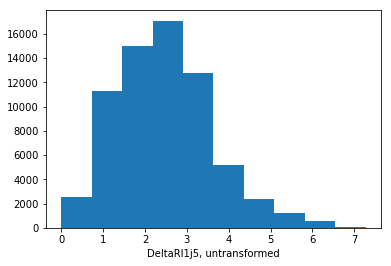

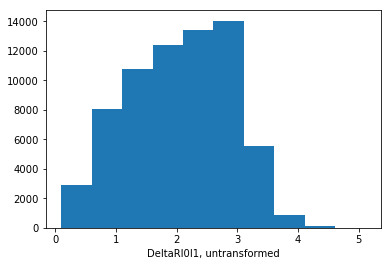

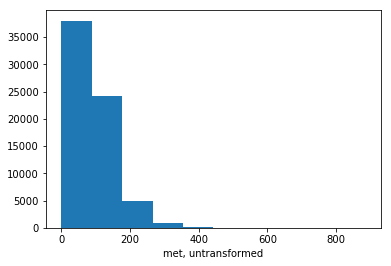

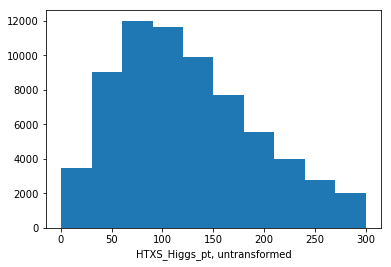

In [16]:
# make the selection and slimming
#data_tth = data[data['evt_tag'] == 1]
skim=True
if skim:
    print('From %s available data '%len(data_tth))
    data_tth = data_tth[data_tth['HTXS_Higgs_pt']<300.]
    print(' you selected %s of them'%len(data_tth))
    #data_tth['HTXS_Higgs_pt'] = data_tth['HTXS_Higgs_pt'].apply(lambda x : x if x<300. else 300.)
preprocess=True
manip=False
target = [thetarget[0]]
#data_tth[target] = np.log(data_tth[target])
if manip:
    datadiff = data_tth[target].values - data_tth[['met']].values
    print(datadiff.shape)
    data_tth[target] = datadiff
#= data_tth[target]-data_tth[['met']]
data_orig_tth = data_tth
#if preprocess:
#    data_tth = data_tth[thevars]

# Move to log
#if 'pt' in target[0]:
#    data_tth[target] = data_tth[target].apply(lambda x : np.log(x))
#for var in thevars+spect+target:
#    if 'pt' and 'Jet' in var:
#        data_tth[var] = data_tth[var].apply(lambda x : np.log(x))

#data["Higgs_pt"] = data["Higgs_pt"].apply(lambda x : min(x,450))
#print data["Higgs_pt"]
# Display the first few rows
viz=False
import seaborn as sns
if viz:
    myviz=data_tth.head(100)
    sns.pairplot(myviz[thevars+target], diag_kind="kde")
    plt.show()
# Must do with subfig or something
for var in thevars+spect+target:
    plt.hist(data_orig_tth[var])
    plt.xlabel('%s, untransformed'%var)
    plt.show()
    

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if False:

    data_tth.head()
    from sklearn_pandas import DataFrameMapper

    mapper = DataFrameMapper([(data_tth.columns, StandardScaler())])
    scaled_features = mapper.fit_transform(data_tth.copy())
    data_tth = pd.DataFrame(scaled_features, index=data_tth.index, columns=data_tth.columns)

    #y = StandardScaler().fit_transform(y.reshape(len(y),1))[:,0]
    print(type(data_tth))
    print(data_tth.shape)

    data_tth.head()


Scaling training features
Transforming training and validation features
Plotting transformed features for the training set


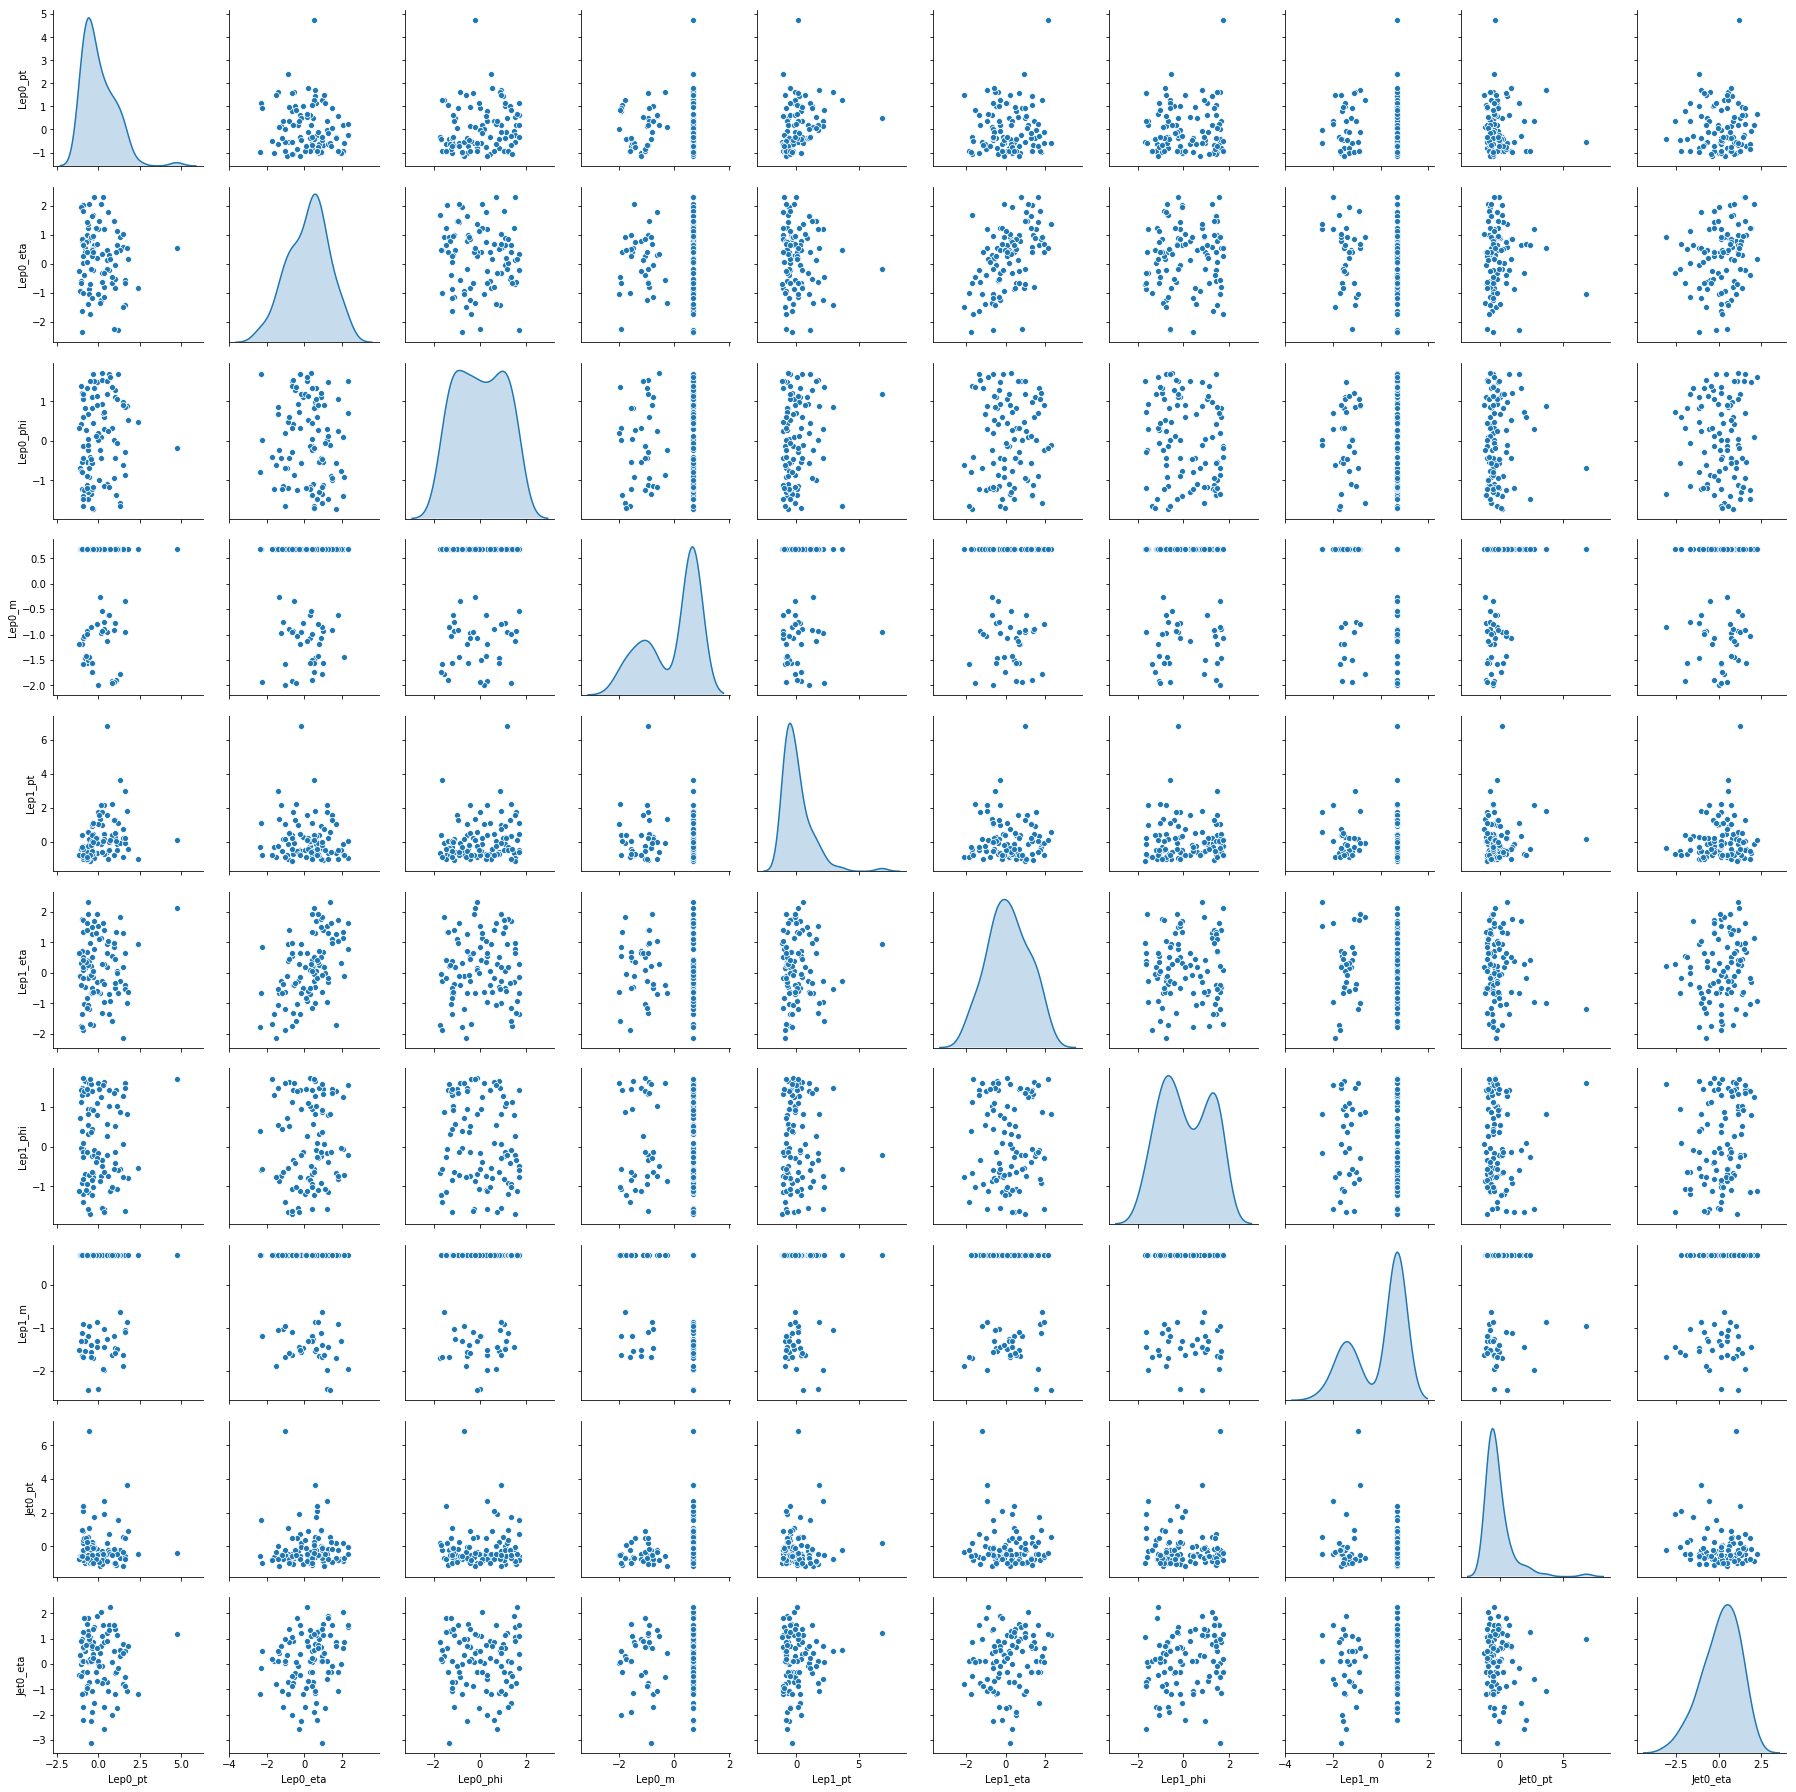

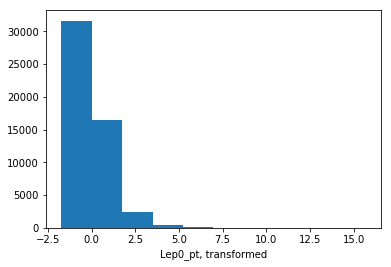

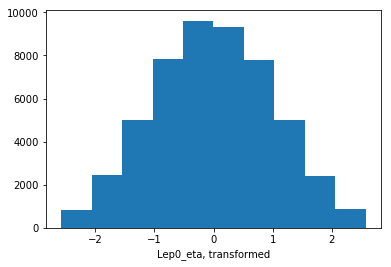

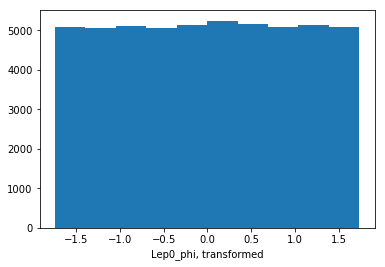

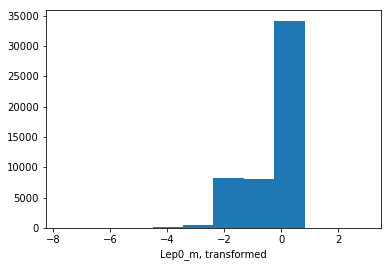

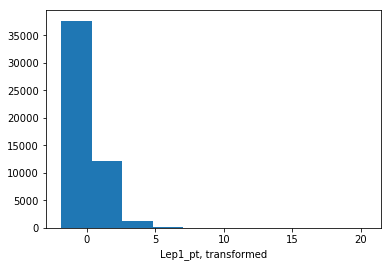

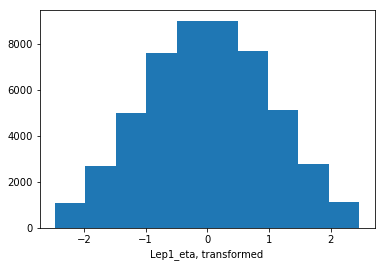

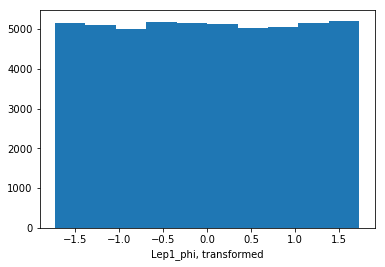

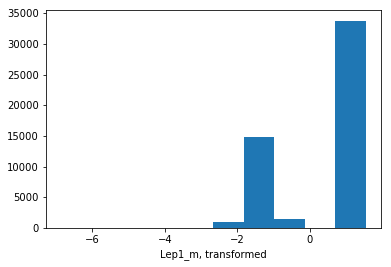

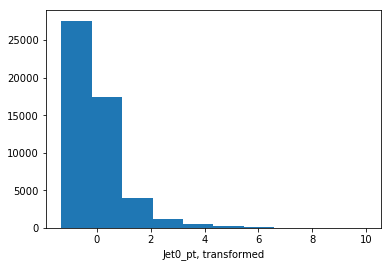

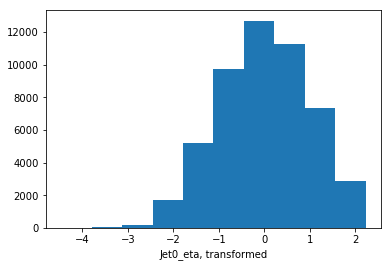

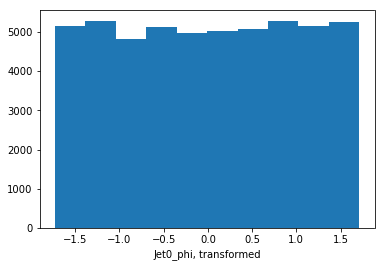

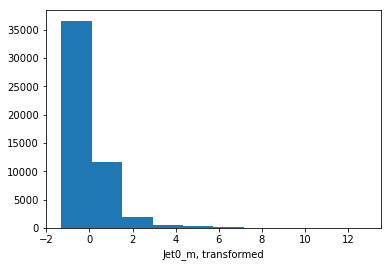

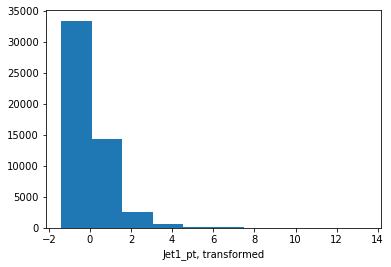

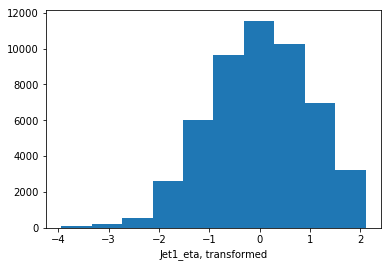

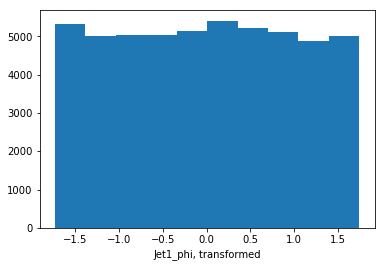

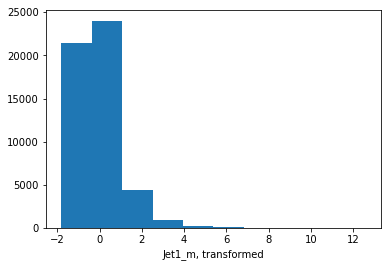

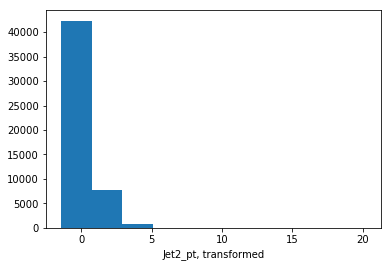

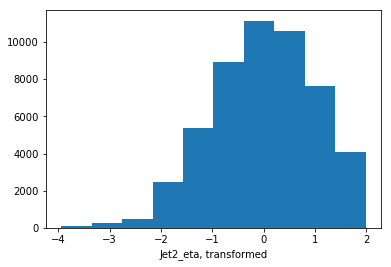

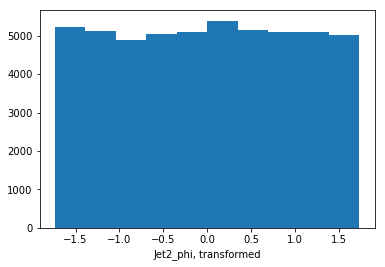

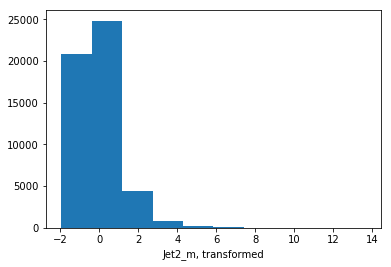

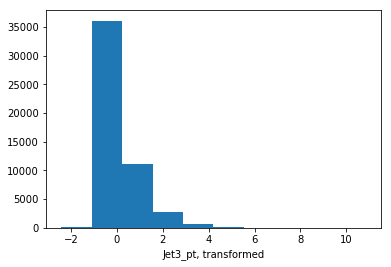

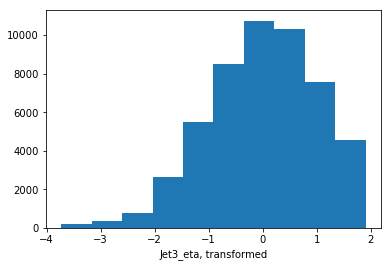

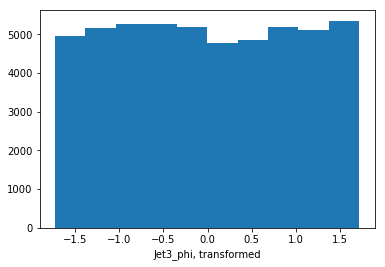

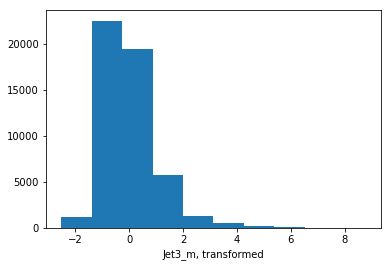

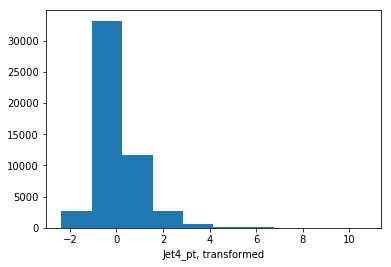

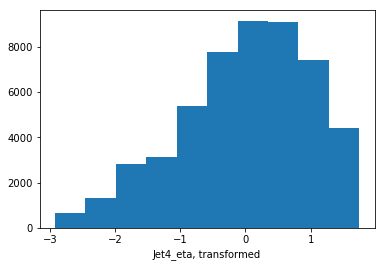

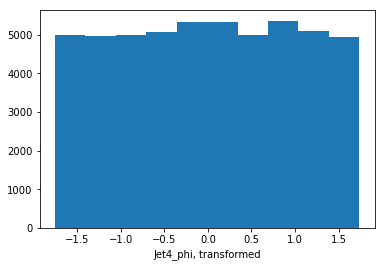

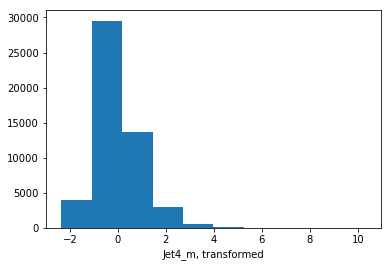

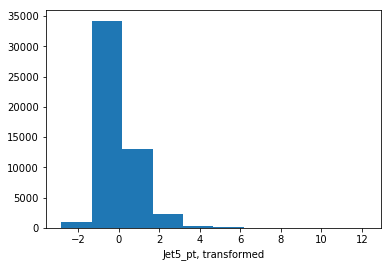

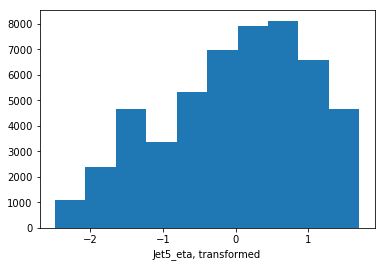

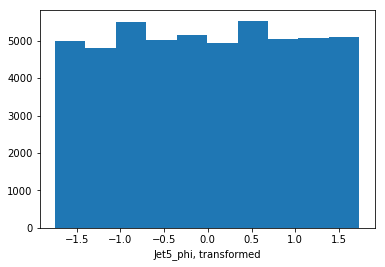

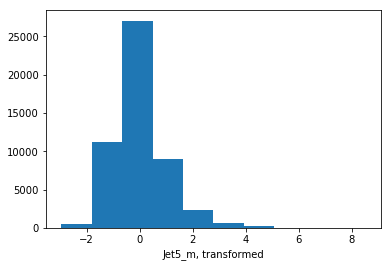

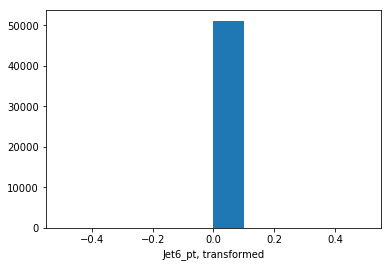

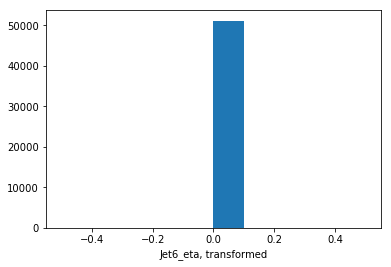

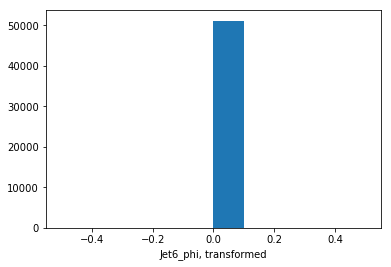

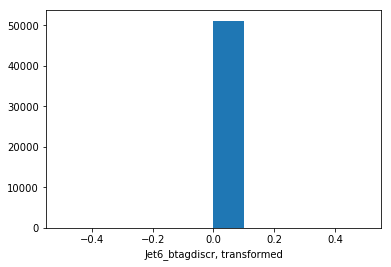

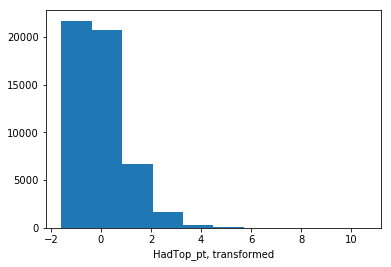

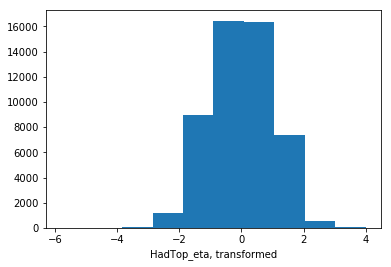

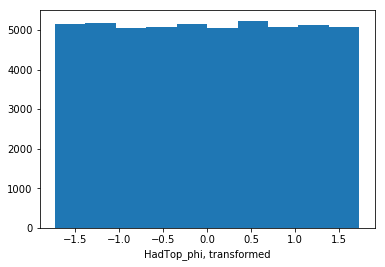

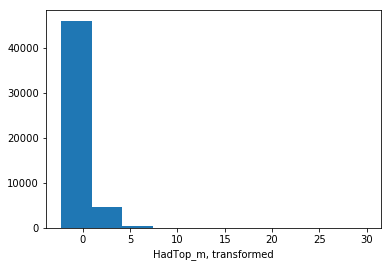

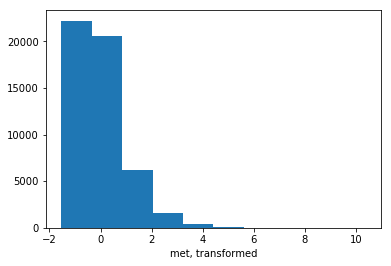

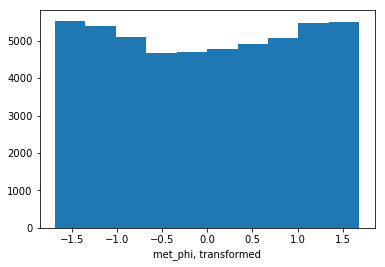

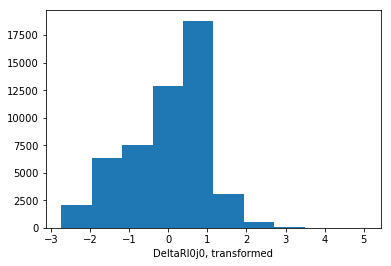

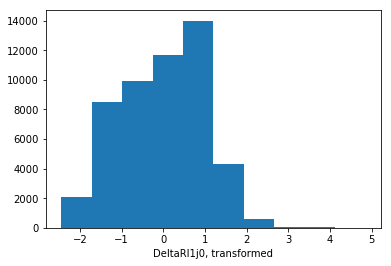

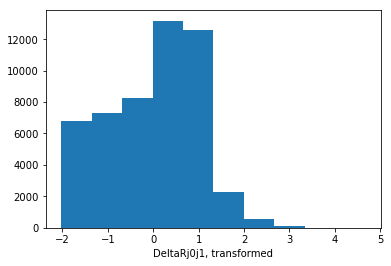

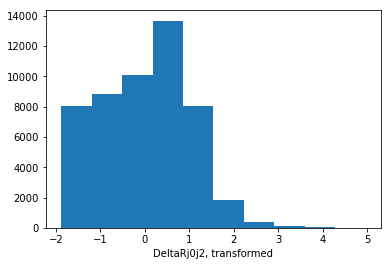

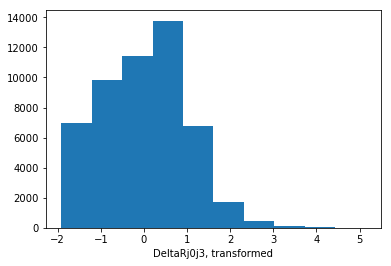

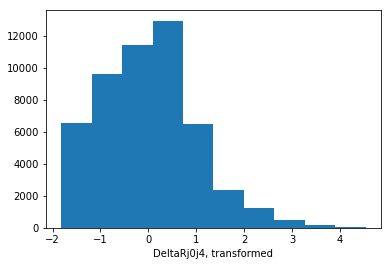

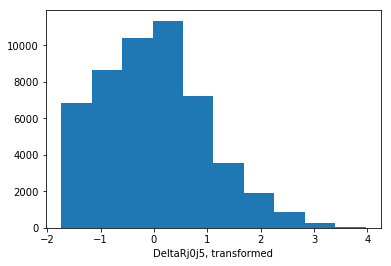

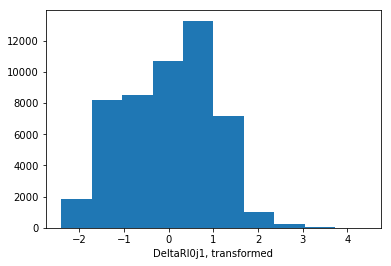

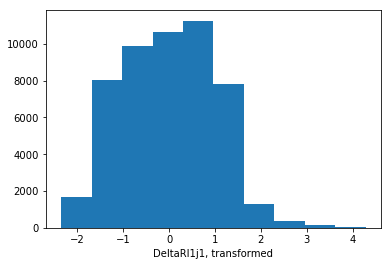

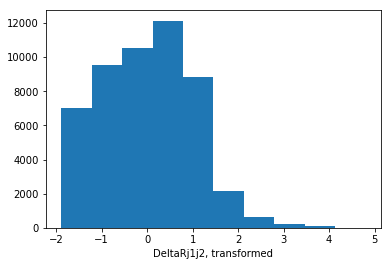

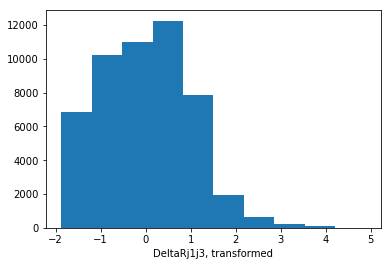

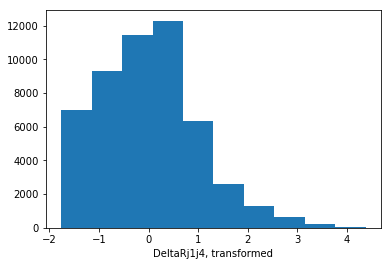

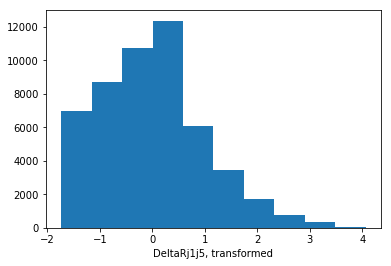

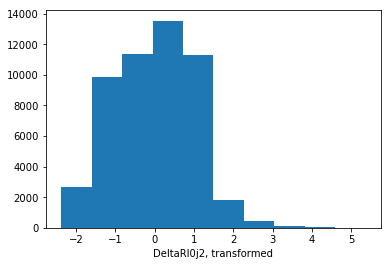

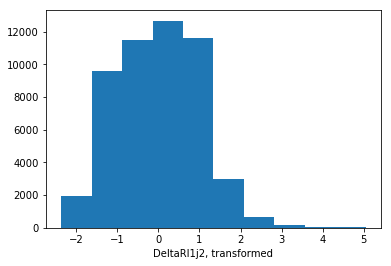

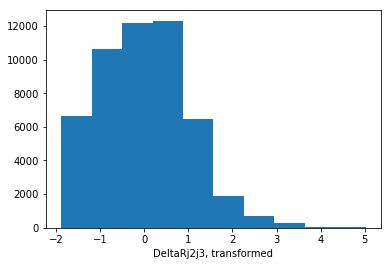

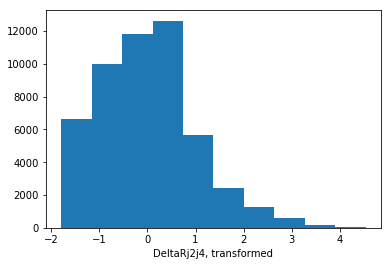

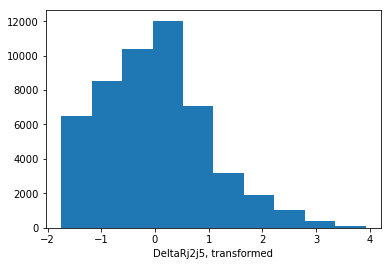

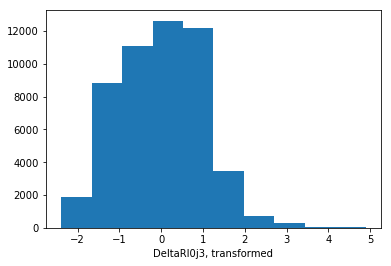

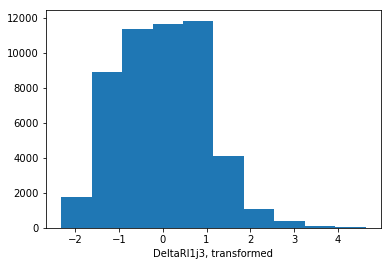

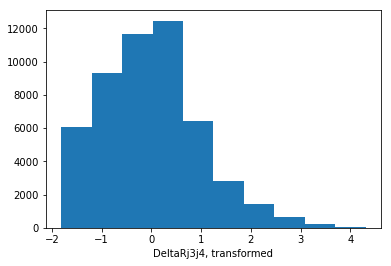

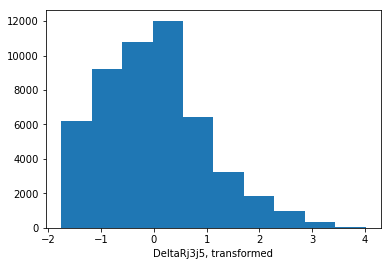

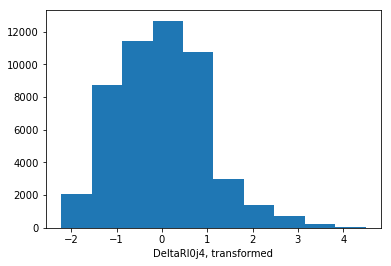

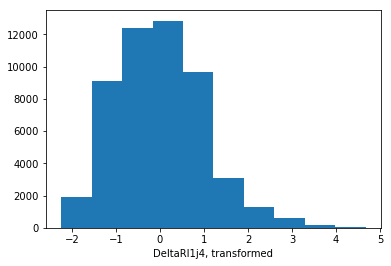

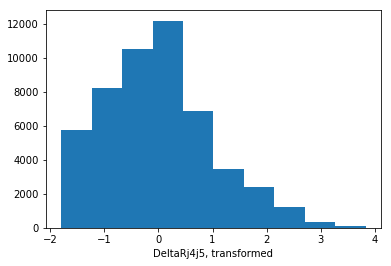

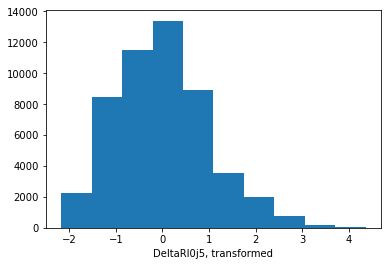

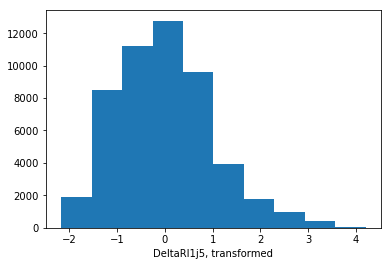

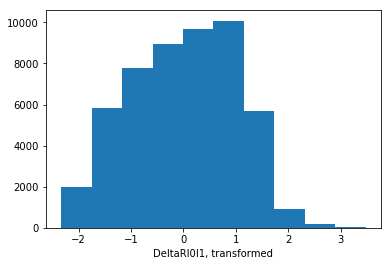

Now plotting training target
(51130, 1)


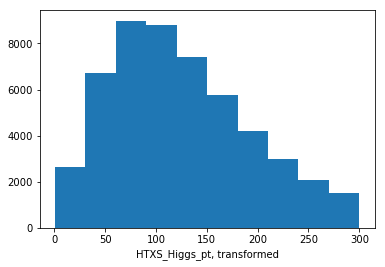

End


In [18]:
if False:
    data_tth[target] = data_orig_tth[target]
    for var in thevars+spect+target:
        plt.hist(data_tth[var])
        plt.xlabel('%s, transformed'%var)
        plt.show()
    

# train and validation

#traindataset, valdataset = train_test_split(data_tth, test_size=0.4, random_state=7)

x_train, x_test, y_train, y_test = train_test_split(data_tth[thevars], data_tth[target], random_state=7)

if preprocess:
    print('Scaling training features')
    scaler = StandardScaler()
    scaler.fit(x_train.values)
    print('Transforming training and validation features')
    x_train_scaled = scaler.transform(x_train.values)
    x_test_scaled = scaler.transform(x_test.values)
    print('Plotting transformed features for the training set')
    myviz=pd.DataFrame(x_train_scaled,columns=data_tth[thevars].columns)
    myviz_short=myviz.head(100)
    sns.pairplot(myviz_short[thevars[:10]], diag_kind="kde")
    plt.show()
    for var in thevars:
        plt.hist(myviz[var])
        plt.xlabel('%s, transformed'%var)
        plt.show()
    for var in target:
        print('Now plotting training target')
        print(y_train.shape)
        plt.hist(y_train[var])
        plt.xlabel('%s, transformed'%var)
        plt.show()
print('End')

In [19]:
print(len(thevars))

70


In [20]:
# The model

def my_model(lr=5e-2):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(len(thevars),)))
    #model.add(Dense(4*len(thevars), input_dim=len(thevars), kernel_initializer='he_normal'))
    model.add(Dense(5*len(thevars), kernel_initializer='glorot_normal'))
    #model.add(PReLU())
    model.add(Activation('linear'))
    model.add(Dropout(0.5))
    #for Nnodes in [80,100,40,16,4]:
    for Nnodes in [4*len(thevars),3*len(thevars),2*len(thevars),len(thevars),50,16]:
    #for Nnodes in [3*len(thevars)]:
    #for Nnodes in [200,100,50,16]:
        model.add(Dense(Nnodes, kernel_initializer='glorot_normal'))
        #model.add(PReLU())
        model.add(Activation('linear'))
        model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='he_normal'))
    model.add(Activation('linear'))
    
    adam = optimizers.adam(lr=lr,amsgrad=True) 
    #model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mse'])
    #model.compile(loss='mean_absolute_error', optimizer=adam)
    #model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    #model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    return model

def my_training(lr,epochs=20):
    my_regression = KerasRegressor(
        build_fn=my_model, 
        epochs=epochs, 
        batch_size=256, 
        verbose=2,
        lr=lr
)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,min_delta=0.0001)
    cb_list = [es]
    history = my_regression.fit(
        x_train if not preprocess else x_train_scaled, 
        y_train,
        validation_data=(
            x_test if not preprocess else x_test_scaled, 
            y_test
        ),
        #callbacks=cb_list
    )
    return my_regression, history


In [21]:
model, hist= my_training(1e-4,epochs=30)
plt.show()


Train on 51130 samples, validate on 17044 samples
Epoch 1/30
 - 4s - loss: 123.3106 - mean_squared_error: 19785.0691 - val_loss: 118.6332 - val_mean_squared_error: 18644.7689
Epoch 2/30
 - 2s - loss: 88.6494 - mean_squared_error: 12183.1623 - val_loss: 55.4288 - val_mean_squared_error: 5211.8441
Epoch 3/30
 - 2s - loss: 72.6394 - mean_squared_error: 8569.4860 - val_loss: 52.8695 - val_mean_squared_error: 4682.2159
Epoch 4/30
 - 2s - loss: 69.4978 - mean_squared_error: 7880.8497 - val_loss: 52.7685 - val_mean_squared_error: 4644.5655
Epoch 5/30
 - 2s - loss: 67.6351 - mean_squared_error: 7476.9012 - val_loss: 52.3337 - val_mean_squared_error: 4544.6531
Epoch 6/30
 - 2s - loss: 66.1923 - mean_squared_error: 7157.1276 - val_loss: 51.6880 - val_mean_squared_error: 4410.8935
Epoch 7/30
 - 2s - loss: 65.0911 - mean_squared_error: 6926.5012 - val_loss: 51.6387 - val_mean_squared_error: 4409.0115
Epoch 8/30
 - 2s - loss: 64.1652 - mean_squared_error: 6745.4145 - val_loss: 51.6251 - val_mean_sq

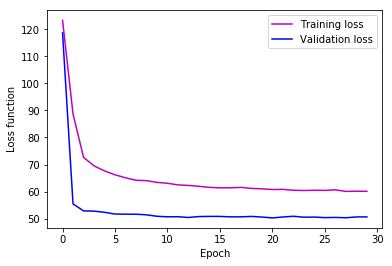

ImportError: No module named eli5

In [27]:
plt.plot(hist.history['loss'],color='m',label='Training loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
plt.show()
#plt.plot(hist.history['mse'], color='m', label='Training MSE')
#plt.plot(hist.history['val_mse'], color='b', label='Validation MSE')
#plt.xlabel('Epoch')
#plt.ylabel('Mean squared error')
#plt.legend(loc='upper right')
#plt.show()

import eli5
from eli5.sklearn import PermutationImportance
doperm=False
if doperm:
    showvarimp=pd.DataFrame(x_train if not preprocess else x_train_scaled,columns=data_tth[thevars].columns)
    perm = PermutationImportance(model, random_state=1).fit(showvarimp,y_train)
    eli5.show_weights(perm, feature_names = showvarimp.columns.tolist())

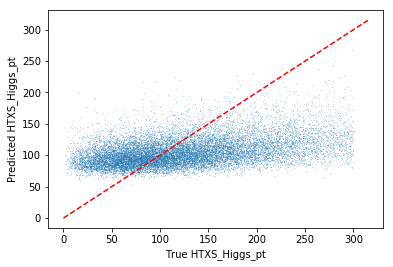

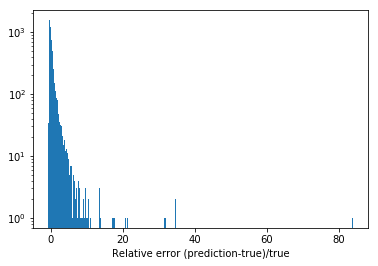

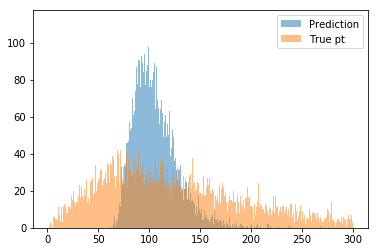

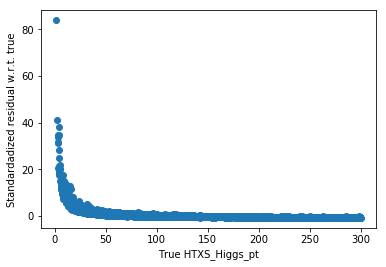

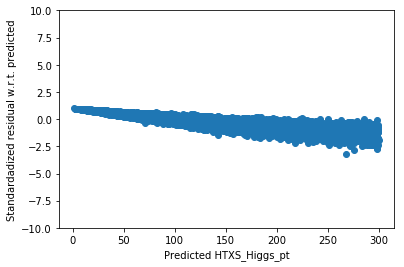

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scipy/1.1.0-ikaegh/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


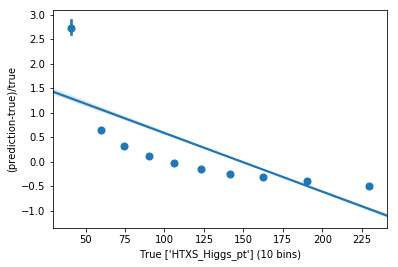

('Shape of prediction:', (17044,))
('Shape of valdataset met:', (17044, 1))
('Shape of valdataset met values:', (17044, 1))
('Linear correlation:', array([[1.        , 0.41319241],
       [0.41319241, 1.        ]]))
('Linear correlation (back to pt):', None)


In [28]:
import seaborn as sns

viz_x_test = x_test if not preprocess else x_test_scaled
viz_x_test=pd.DataFrame(viz_x_test,columns=data_tth[thevars].columns)
prediction = model.predict(viz_x_test.values)
lincorr = np.corrcoef(prediction, np.transpose(y_test))
#vexp = np.vectorize(math.exp)
#blah = plt.scatter(vexp(y_test[target].values),vexp(prediction),s=0.01)
blah = plt.scatter(y_test[target].values,prediction,s=0.01)
if manip:
    plt.xlabel('True %s-%s'%(target[0],'met'))
    plt.ylabel('Predicted %s-%s'%(target[0],'met'))
else:
    plt.xlabel('True %s'%target[0])
    plt.ylabel('Predicted %s'%target[0])
    myxlim = plt.xlim()
    myylim = plt.ylim()
    lowcoord = min(myxlim[0],myylim[0]) if 'HTXS_Higgs_pt' not in target else 0
    higcoord = max(myxlim[1],myylim[1])
_ = plt.plot([lowcoord,higcoord],[lowcoord,higcoord], c='red',ls='--')
plt.show()
diff = prediction-y_test[target].values.reshape(-1)
plt.hist(diff/y_test[target].values.reshape(-1),log=True,bins=1000)
plt.xlabel('Relative error (prediction-true)/true')
plt.show()
lincorrbacktopt=None
if manip:
    valbacktopt=y_test[target].values + viz_x_test[['met']].values
    predbacktop=prediction+viz_x_test[['met']].values.reshape(-1)
    plt.scatter(valbacktopt, predbacktop, s=0.01)
    plt.xlabel('True %s'%(target[0]))
    plt.ylabel('Predicted %s'%(target[0]))
    lincorrbacktopt = np.corrcoef(predbacktop, np.transpose(valbacktopt))
    plt.show()
    plt.hist(valbacktopt,alpha=0.5,log=False,bins=1000,label='True pt')
    plt.hist(predbacktop,alpha=0.5,log=False,bins=1000,label='Prediction')
    plt.legend(loc='upper right')
    plt.show()
    sns.regplot(valbacktopt,diff/valbacktopt.reshape(-1),x_bins=10)
    if bkgs:
        ttv_prediction = model.predict(data_ttv[thevars].values)
        tt_prediction = model.predict(data_tt[thevars].values)
        ttv_manip = ttv_prediction+ data_ttv[['met']].values.reshape(-1)
        tt_manip = tt_prediction + data_tt[['met']].values.reshape(-1)
        plt.hist(predbacktop,alpha=0.5,density=True,log=True,bins=500,label='TTH Prediction')
        plt.hist(ttv_manip,alpha=0.5,density=True,log=True,bins=500,label='TTV Prediction')
        plt.hist(tt_manip,alpha=0.5,density=True,log=True,bins=500,label='TT Prediction')
        plt.legend(loc='upper right')
        plt.show()
else:
    #plt.hist(vexp(prediction),alpha=0.5,log=False,bins=1000,label='Prediction')
    #plt.hist(vexp(y_test[target].values),alpha=0.5,log=False,bins=1000,label='True pt')
    plt.hist(prediction,alpha=0.5,log=False,bins=1000,label='Prediction')
    plt.hist(y_test[target].values,alpha=0.5,log=False,bins=1000,label='True pt')
    plt.legend(loc='upper right')
    plt.show()
    plt.scatter(y_test.values,diff/y_test[target].values.reshape(-1))
    #plt.scatter(y_test[target].values,diff)
    plt.xlabel('True %s'%target[0])
    plt.ylabel('Standardadized residual w.r.t. true')
    plt.show()
    plt.scatter(y_test[target].values,diff/prediction.reshape(-1))
    plt.ylim(-10,10)
    #plt.scatter(prediction,diff)
    plt.xlabel('Predicted %s'%target[0])
    plt.ylabel('Standardadized residual w.r.t. predicted')
    plt.show()
    nxbins=10
    ax = sns.regplot(y_test[target].values,diff/y_test[target].values.reshape(-1),x_bins=nxbins)
    ax.set(xlabel='True %s (%s bins)'%(target,nxbins), ylabel='(prediction-true)/true')
    plt.show()
    if bkgs:
        ttv_prediction = model.predict(data_ttv[thevars].values)
        tt_prediction = model.predict(data_tt[thevars].values)
        ttv_manip = ttv_prediction+ data_ttv[['met']].values.reshape(-1)
        tt_manip = tt_prediction + data_tt[['met']].values.reshape(-1)
        plt.hist(prediction,alpha=0.5,density=True,log=True,bins=500,label='TTH Prediction')
        plt.hist(ttv_manip,alpha=0.5,density=True,log=True,bins=500,label='TTV Prediction')
        plt.hist(tt_manip,alpha=0.5,density=True,log=True,bins=500,label='TT Prediction')
        plt.legend(loc='upper right')
        plt.show()
print('Shape of prediction:', prediction.shape)
print('Shape of valdataset met:', viz_x_test[['met']].shape)
print('Shape of valdataset met values:', viz_x_test[['met']].values.shape)
print('Linear correlation:', lincorr)
print('Linear correlation (back to pt):', lincorrbacktopt)

In [29]:
# Temporary crap
chappy=valdataset[target].values + valdataset[['met']].values
plt.hist(chappy)
plt.hist(valdataset[target].values
        )

NameError: name 'valdataset' is not defined

In [ ]:
# Temporary crap
diffm = predbacktop-valbacktop
plt.hist(diffm)

In [30]:
print(len(thevars))

70


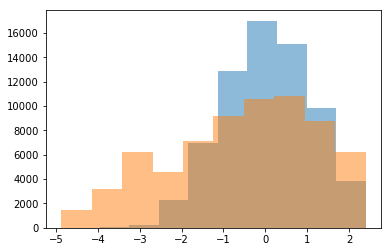

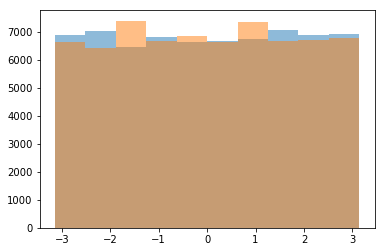

In [31]:
plt.hist(data_tth['Jet0_eta'], alpha=0.5)
plt.hist(data_tth['Jet5_eta'], alpha=0.5)
plt.show()
plt.hist(data_tth['Jet0_phi'], alpha=0.5)
plt.hist(data_tth['Jet5_phi'], alpha=0.5)
plt.show()


In [ ]:
print/